<a href="https://colab.research.google.com/github/amadousysada/ecommerce-customer-segmentation/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

OLIST DATABASE

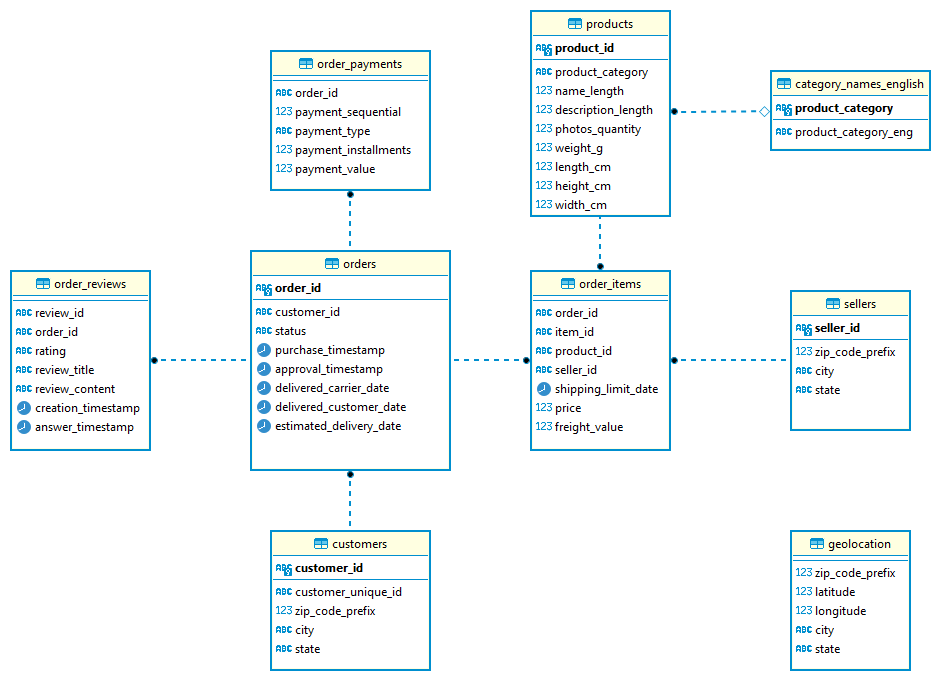

In [ ]:
import pandas as pd
from sqlite3 import connect

# Requêtes SQL pour le Dashboard

* En excluant les commandes annulées, quelles sont les commandes
récentes de moins de 3 mois que les clients ont reçues avec au moins 3
jours de retard ?

* Qui sont les vendeurs ayant généré un chiffre d'affaires de plus de 100
000 Real sur des commandes livrées via Olist ?

* Qui sont les nouveaux vendeurs (moins de 3 mois d'ancienneté) qui
sont déjà très engagés avec la plateforme (ayant déjà vendu plus de 30
produits) ?

* Question : Quels sont les 5 codes postaux, enregistrant plus de 30
reviews, avec le pire review score moyen sur les 12 derniers mois ?

In [ ]:
folder_path = "/content/drive/MyDrive/data/" # A ajuster selon le chemin où se trouve votre fichier .db

In [ ]:
db_path = f"{folder_path}olist.db"
conn = connect(db_path)
cur = conn.cursor()

## Les tables de la base de données olist

In [ ]:
query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql(query, conn)
print(tables)

            name
0      customers
1         geoloc
2    order_items
3    order_pymts
4  order_reviews
5         orders
6       products
7        sellers
8    translation


# Récupération des données

In [145]:
def extract_transform_and_load_olist_data():

  # Extract orders
  print("Extraction des commandes ...")
  orders = pd.read_sql(
    """
    SELECT
      order_id,
      customer_id,
      order_purchase_timestamp,
      order_approved_at,
      order_delivered_carrier_date,
      order_delivered_customer_date,
      order_estimated_delivery_date
    FROM orders o
    WHERE o.order_status='delivered'
    """,
    conn
  )

  # Extract order items
  print("Extraction des articles ...")
  items = pd.read_sql(
    """
    SELECT
      oi.order_id,
      COUNT(order_item_id) as nbre_items,
      SUM(price+freight_value) as total_price,
      COUNT(DISTINCT oi.product_id) AS distinct_products
    FROM order_items oi
    JOIN orders o on oi.order_id=o.order_id
    WHERE o.order_status='delivered'
    GROUP BY oi.order_id
    """,
    conn
  )

  # Extract customers
  print("Extraction des clients ...")
  customers = pd.read_sql(
    """
    SELECT
      o.order_id,
      customer_unique_id,
      customer_zip_code_prefix,
      customer_city,
      customer_state
    FROM customers c
    JOIN orders o on o.customer_id = c.customer_id
    WHERE o.order_status='delivered'
    """,
    conn
  )

  # Extract reviews
  print("Extraction des commentaires ...")
  reviews = pd.read_sql(
    """
    SELECT
      o.order_id,
      COUNT(r.review_id) as total_reviews,
      COALESCE(AVG(r.review_score), 0) AS mean_score_review
    FROM orders o
    LEFT JOIN order_reviews r on o.order_id=r.order_id
    WHERE o.order_status='delivered'
    GROUP BY o.order_id
    """,
    conn
  )

  # Extract payments
  print("Extraction des paiments ...")
  payments = pd.read_sql(
    """
    SELECT
      p.order_id,
      MAX(payment_installments) as payment_installments,
      SUM(payment_value) as payment_value
    FROM order_pymts p
    JOIN orders o on o.order_id=p.order_id
    WHERE o.order_status='delivered'
    GROUP BY p.order_id
    """,
    conn
  )
  print("--"*20)

  # Tranform

  print("Merger des items ...")
  data = orders.merge(items, on='order_id')

  print("Merger des clients ...")
  data = data.merge(customers, on='order_id')

  print("Merger des paiments ...")
  data = data.merge(reviews, on='order_id')

  print("Merger des paiments ...")
  data = data.merge(payments, on='order_id')

  print("--"*20)
  print(f"Dimension du dataset: {data.shape}")

  return data

In [146]:
data = extract_transform_and_load_olist_data()

Extraction des commandes ...
Extraction des articles ...
Extraction des clients ...
Extraction des commentaires ...
Extraction des paiments ...
----------------------------------------
Merger des items ...
Merger des clients ...
Merger des paiments ...
Merger des paiments ...
----------------------------------------
Dimension du dataset: (96477, 18)
